In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

In [2]:
df = pd.read_csv('inspect_training_set.csv', skiprows=1)

In [3]:
df_test = df.iloc[2:, 1:3].copy()

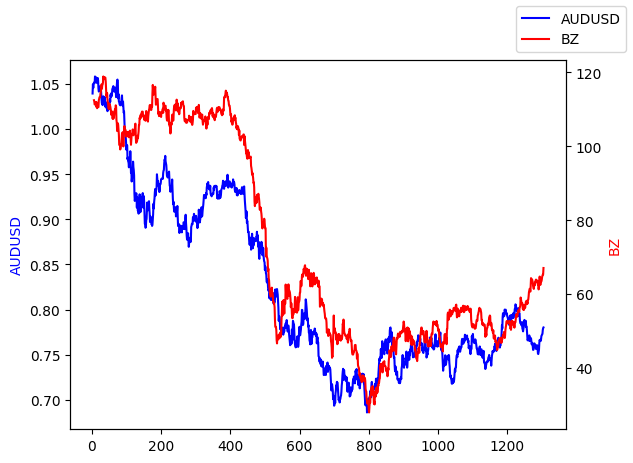

In [4]:
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first dataset
ax1.plot(df_test.iloc[:,0], 'b-', label='AUDUSD')
ax1.set_ylabel('AUDUSD', color='b')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df_test.iloc[:,1].shift(4), 'r-', label='BZ')
ax2.set_ylabel('BZ', color='r')

fig.legend()

**Steps**
1. Consider smoothing the price time-series for more meaningful lead-lag relationship analysis
2. Linear vs. non-linear leading relationships to consider
3. Test it out

**Things to flag out**
- Data needs to be in a more easily readable format (Not multi-layer column headers)
- Need to find a way to install the Transfer Entropy package

In [5]:
# Granger Causality (Linear relationship)
def check_stationarity(time_series):
    result = adfuller(time_series)
    return result[1]  # Return the p-value

def transform_to_stationary(df):
    diff_df = df.diff().dropna()
    return diff_df

def find_optimal_lag(df, max_lag):
    model = VAR(df)
    lag_order = model.select_order(maxlags=max_lag)
    return lag_order.bic

def granger_causality_test(df, max_lag):
    results = {}
    for lag in range(1, max_lag + 1):
        result = grangercausalitytests(df, lag, verbose=False)
        p_values = [round(test[0]['ssr_chi2test'][1], 4) for test in result.values()]
        results[lag] = p_values
    
    optimal_lag = None
    for lag, p_values in results.items():
        if all(p < 0.05 for p in p_values):
            optimal_lag = lag
            break
    
    return optimal_lag, results

def find_leading_variable(df, max_lag=10):
    # Step 1: Check stationarity and transform if necessary
    is_stationary_X = check_stationarity(df.iloc[:,0]) < 0.05
    is_stationary_Y = check_stationarity(df.iloc[:,1]) < 0.05
    
    if not is_stationary_X or not is_stationary_Y:
        df = transform_to_stationary(df)
    
    # Step 2: Find the optimal lag using VAR model
    optimal_lag = find_optimal_lag(df, max_lag)
    
    # Step 3: Perform Granger causality test
    optimal_lag, causality_results = granger_causality_test(df, optimal_lag)
    
    if optimal_lag is None:
        return None, None
    
    # Step 4: Determine the leading variable
    p_values = causality_results[optimal_lag]
    leading_variable = 'X leads Y' if p_values[0] < 0.05 else 'Y leads X'
    
    return leading_variable, optimal_lag

